In [65]:
import pandas as pd
import numpy as np
from datetime import datetime

In [66]:
var_importance_ids = None

#### Load the dataset and preprocess
- Load preprocessed dataset from "preprocessing_sub" script

In [ ]:
df = pd.read_csv("preprocessed_dataset.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [68]:
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:03:00,56.39,13.53,2082.27,391.733,403.738,9.70067,1.74925,250.509,251.163,250.610,...,250.389,249.430,606.023,596.422,604.776,437.700,430.352,433.920,443.036,1.40
2017-03-10 01:03:20,55.20,16.98,3019.53,557.434,395.713,10.06640,1.74000,249.214,253.235,250.576,...,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,1.31
2017-03-10 01:03:40,55.20,16.98,3024.41,563.965,397.383,10.06720,1.74000,249.719,250.532,250.862,...,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,1.31
2017-03-10 01:04:00,55.20,16.98,3043.46,568.054,399.668,10.06800,1.74000,249.741,247.874,250.313,...,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,1.31
2017-03-10 01:04:20,55.20,16.98,3047.36,568.665,397.939,10.06890,1.74000,249.917,254.487,250.049,...,250.422,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,1.31


#### Additional preprocessing
- final preprocessing: downsample to hourly intervals
- define the well-functioning time frames

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from model import Model 
from sklearn.metrics import mean_squared_error
import progressbar  # pip install progressbar2
import copy
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

def q2_score(Y, y_t, y_fit_t):
    tss_res = np.sum((np.array(Y) - np.mean(Y))**2) + 1e-10
    press = np.sum((np.array(y_t) - np.array(y_fit_t))**2) + 1e-10
    return 1. - press / tss_res

def r2_score(Y, y_fit):
    tss_res = np.sum((np.array(Y) - np.mean(Y))**2) + 1e-10
    press = np.sum((np.array(Y) - np.array(y_fit))**2) + 1e-10
    return 1. - press / tss_res

df_array = df.to_numpy()
print(df_array.shape)

# Reduce the amount of observations (with averaging)
df = df.resample("H").mean()

included_rows1 = [df.index.get_loc(datetime(2017, 4, 23, 19, 0, 00)),
                    df.index.get_loc(datetime(2017, 5, 13, 0, 0, 00))]
included_rows2 = [df.index.get_loc(datetime(2017, 6, 15, 1, 0, 00)),
                    df.index.get_loc(datetime(2017, 7, 24, 0, 0, 00))]
included_rows3 = [df.index.get_loc(datetime(2017, 8, 15, 1, 0, 00)),
                    df.index.get_loc(datetime(2017, 9, 10, 0, 0, 00))]

df_array = df.to_numpy()
print(df_array.shape)


(737454, 22)
(4416, 22)


#### PLS loop
Define windows, maximum no. components that should be used
Define no. input variables to use if importance of variables defined
PLS loop performing: 
- windowing, 
- normalization, 
- fitting, 
- and metrics evaluation.

In [ ]:
models = []
max_comp_num = 12
windows = [5, 10, 15, 20, 25, 30, 35]

In [ ]:
if var_importance_ids is not None:    
    input_vars_count = 30
    if input_vars_count < max_comp_num:
        max_comp_num = input_vars_count
    
    mses = []
    q2s = []
    r2s = []

In [ ]:
filtering_count = 0
not_filtered_count = 0
not_filtered_p = []

for window_size in progressbar.progressbar(windows):
        # Division of data into training and test sets for the normal functioning times:
        # about 85% for training, 15% for testing
        test_size = round(0.15 * window_size)
        test_start = '2017-04-23 20:00:00' # start of test partition
        test_start = datetime.strptime(test_start, '%Y-%m-%d %H:%M:%S')

        # Models with same window size (they all take the same windows, no need to get them multiple times...)
        models_one_win_size = [Model((window_size, i), [], []) 
                               for i in range(2, max_comp_num)]
        print("Start...")
        flag = 0
        iteration_count = 0
        row_number = df.index.get_loc(test_start)
        # Iterate through the data
        while flag == 0:
            
            iteration_count += 1
            if iteration_count % 1000 == 0:    
                print(iteration_count)
                
            test_data, training_data = None, None
            test_y_end = row_number + test_size + 1
            training_X_start = row_number - round(0.85 * window_size)
            
            # Stay within included rows
            if ((test_y_end <= included_rows1[1] and training_X_start - 2 >= included_rows1[0])
                or (test_y_end <= included_rows2[1] and training_X_start - 2 >= included_rows2[0])
                or (test_y_end <= included_rows3[1] and training_X_start - 2 >= included_rows3[0])):

                scaler = StandardScaler()
                center_corr = np.mean(df_array[training_X_start+1:row_number+1, -1])

                # Test set
                test_X_lag1 = df_array[row_number:test_y_end-1,:-1]
                test_X_lag2 = df_array[row_number-1:test_y_end-2,:-1]
                test_X_lag3 = df_array[row_number-2:test_y_end-3,:-1]
                
                test_X = np.hstack((test_X_lag1, test_X_lag2, test_X_lag3))
                test_y = df_array[row_number+1:test_y_end,-1]

                # Training set
                training_X_lag1 = df_array[training_X_start:row_number,:-1]
                training_X_lag2 = df_array[training_X_start-1:row_number-1,:-1]
                training_X_lag3 = df_array[training_X_start-2:row_number-2,:-1]
                
                training_X = np.hstack((training_X_lag1, training_X_lag2, training_X_lag3))
                training_y = df_array[training_X_start+1:row_number+1,-1]
                
                if var_importance_ids is not None:
                    test_X = test_X[:, var_importance_ids]
                    training_X = training_X[:, var_importance_ids]
                    test_X = test_X[:, :input_vars_count]
                    training_X = training_X[:, :input_vars_count]
                
                # Check if a value in test set is clearly outside of the range of training set
                n_range = 3
                range_size = np.max(training_y)-np.min(training_y)
                training_y_limits = [np.min(training_y)-n_range*range_size, np.max(training_y)+n_range*range_size]
                range_size = np.max(training_X, axis=0)-np.min(training_X, axis=0)
                training_X_limits = [np.min(training_X, axis=0)-n_range*range_size, np.max(training_X, axis=0)+n_range*range_size]
                if ((test_y < training_y_limits[0]).any()
                    or (test_y > training_y_limits[1]).any()
                    or (test_X < training_X_limits[0]).any() 
                    or (test_X > training_X_limits[1]).any()):
                    test_data, training_data = None, None
                    filtering_count += 1
                        
                else:
                    not_filtered_count += 1
                
                    # Center y
                    test_y = test_y - center_corr
                    training_y = training_y - center_corr

                    # Compute the mean and std with training data
                    scaler.fit(training_X)
                    # Perform standardization for X
                    training_X = scaler.transform(training_X)
                    test_X = scaler.transform(test_X)

                    # Lagged predictor variables and the response variable in one matrix
                    test_data = np.column_stack([test_X, test_y])
                    training_data = np.column_stack([training_X, training_y])

                    # Add the same scaler to all the models with same window size
                    for model in models_one_win_size:
                        model.scalers.append(copy.deepcopy(scaler))
                        model.y_centers.append(copy.deepcopy(center_corr))
                    
                flag = 1 if test_y_end == included_rows3[1] else 0
            else:
                flag = 1 if test_y_end > included_rows3[1] else 0    
            row_number += 1
            
            ######################    
            # Data window generated, all models here have same window size, only different num of components...
            if test_data is None or training_data is None or np.all(test_data[:, :-1] == 0.):
                continue

            # Iterate through all the models with same window size and fit, predict, get metrics
            for model in models_one_win_size:
                train_win_X = np.array(training_data[:, :-1])
                train_win_y = np.expand_dims(np.array(training_data[:, -1]), 1)
                model.model.append(PLSRegression(n_components=model.num_components))
                
                try:
                    model.model[-1].fit(train_win_X, train_win_y)
                except Exception as e:
                    #print(row_number) # , "\n", train_win_X, "\n", train_win_y, "\n", e)
                    continue
                
                test_win_X = test_data[:, :-1]
                test_win_y = np.expand_dims(np.array(test_data[:, -1]), 1)
                
                # Predict the target values                 
                y_train_pred = model.model[-1].predict(train_win_X)
                y_test_pred = model.model[-1].predict(test_win_X)
                
                model.test_metrics[0].append(mean_squared_error(test_win_y, y_test_pred))
                model.test_metrics[1].append(q2_score(train_win_y, test_win_y, y_test_pred))

                model.train_metrics[0].append(mean_squared_error(train_win_y, y_train_pred))
                model.train_metrics[2].append(r2_score(train_win_y, y_train_pred))
                
                # mse.append(mean_squared_error(test_win_y, y_test_pred))
                # r2.append(r2_score(train_win_y, y_train_pred))
                # q2.append(q2_score(train_win_y, test_win_y, y_test_pred))
                    
        not_filtered_p.append(not_filtered_count/(filtering_count+not_filtered_count))
        filtering_count = 0
        not_filtered_count = 0

        models.extend(models_one_win_size)
        
        # mses.append(np.mean(mse))
        # r2s.append(np.mean(r2))
        # q2s.append(np.mean(q2))
        
        for model in models_one_win_size:
            print(f"Saving model with window size: {model.window_size} and No. component: {model.num_components}...")
            # print(model.model[-1].coef_)
            dump(model, f"{model.window_size}_{model.num_components}_model.joblib")


#### Show metrics for different no. input variables
- MSE plot
- R2 plot
- Q2 plot

63


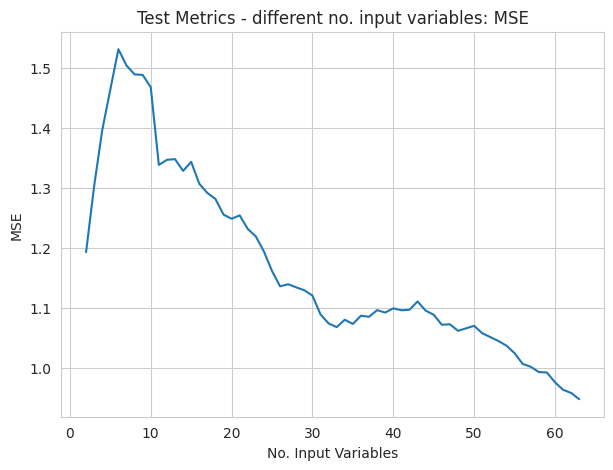

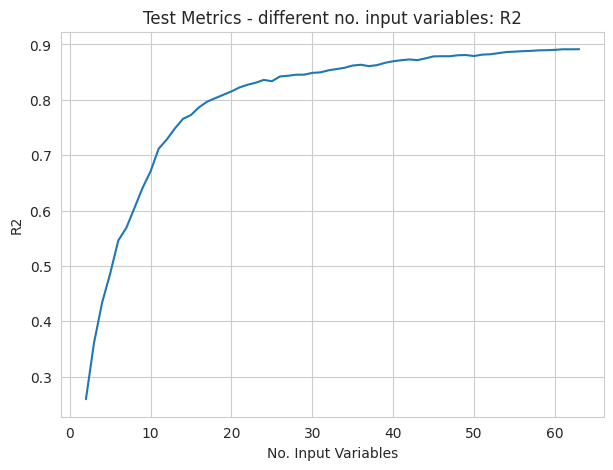

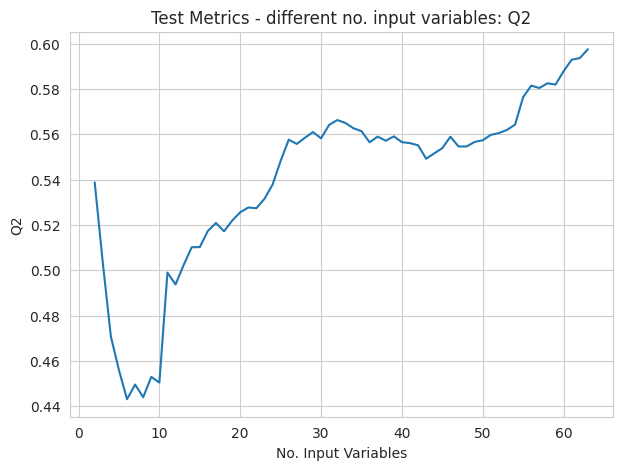

In [64]:
_, ax = plt.subplots(figsize=(7, 5))
plt.plot(range(1, len(mses) + 1), mses)
plt.title('Test Metrics - different no. input variables: MSE')
ax.set(ylabel="MSE", xlabel="No. Input Variables")
plt.show()

_, ax = plt.subplots(figsize=(7, 5))
plt.plot(range(1,  len(mses) + 1), r2s)
plt.title('Test Metrics - different no. input variables: R2')
ax.set(ylabel="R2", xlabel="No. Input Variables")
plt.show()

_, ax = plt.subplots(figsize=(7, 5))
plt.plot(range(1,  len(mses) + 1), q2s)
plt.title('Test Metrics - different no. input variables: Q2')
ax.set(ylabel="Q2", xlabel="No. Input Variables")
plt.show()


#### Load saved models

In [71]:
import os
folder = "all_vars/"
models = []
for win_size in windows:
    for i in range(1, max_comp_num):
        models.append(load(os.path.join(folder, f"{win_size}_{i}_model.joblib")))

#### Show Q2 heatmap

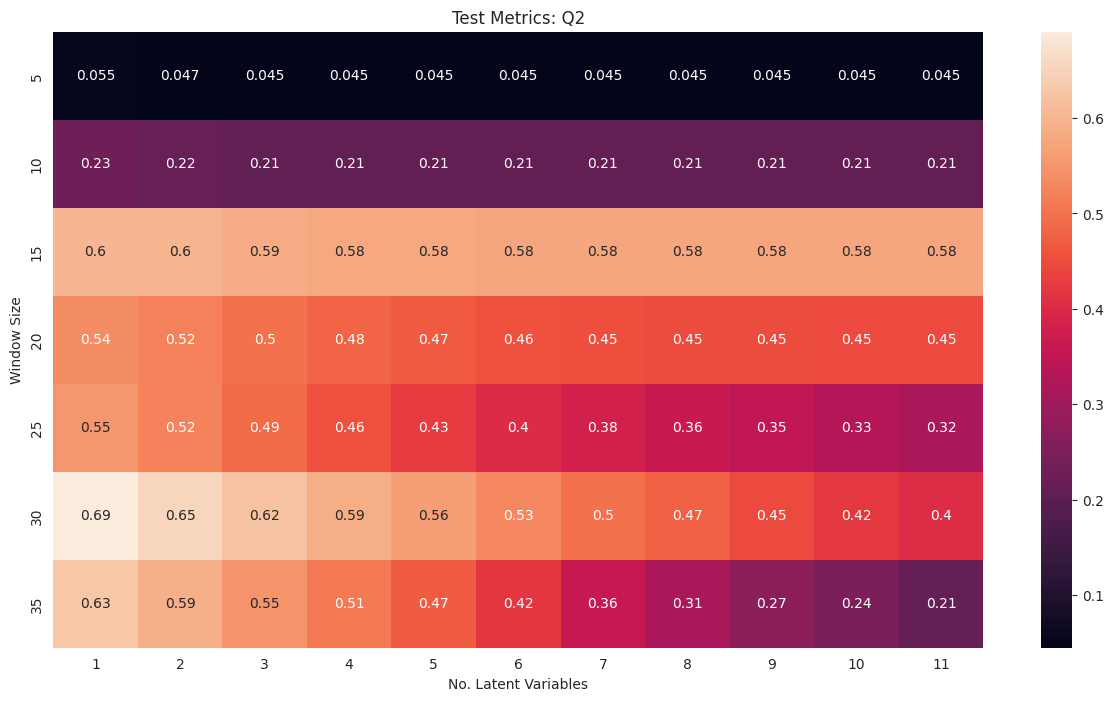

In [72]:
from seaborn import heatmap
from matplotlib.axes import Axes

lv_count = max_comp_num - 1

metrics = np.zeros((len(windows), lv_count))
for model in models:
    metric = np.array(model.test_metrics[1])
    if model.num_components > lv_count: 
        continue
    metrics[windows.index(model.window_size), model.num_components - 1] = np.mean(metric)
    
fig, _ = plt.subplots(figsize=(15, 8))
ax = heatmap(metrics, annot=True, xticklabels=range(1, lv_count + 1), yticklabels=windows)
plt.title('Test Metrics: Q2')
ax.set(ylabel="Window Size", xlabel="No. Latent Variables")
plt.show()

#### Show MSE heatmap

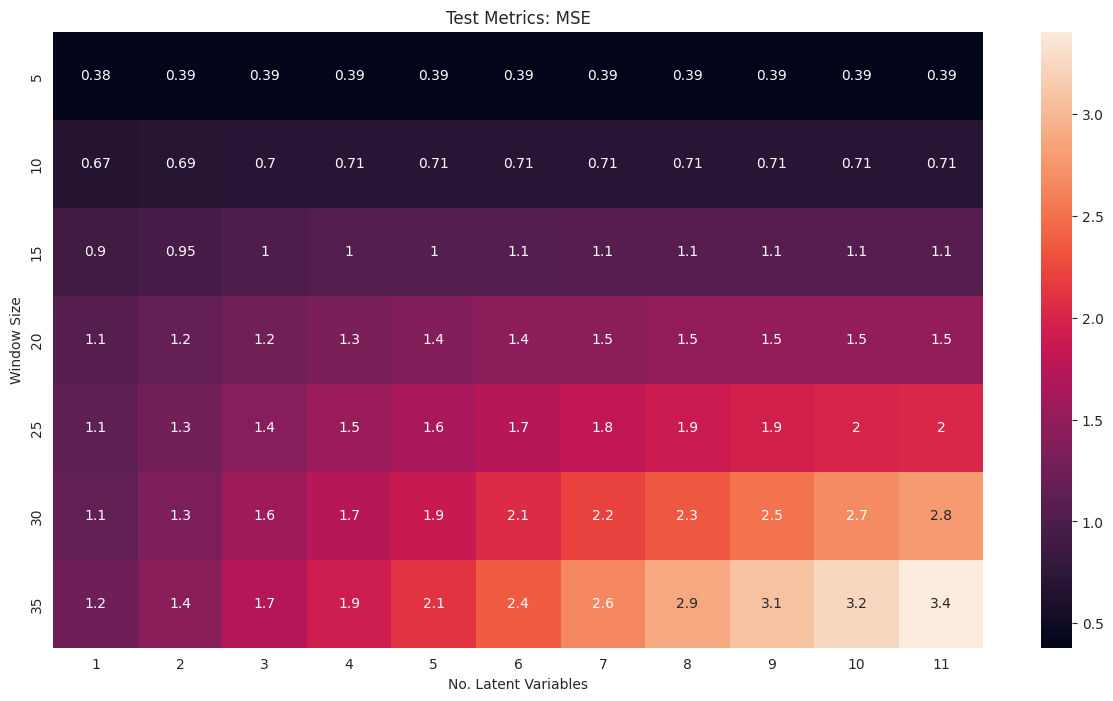

In [73]:
metrics = np.zeros((len(windows), lv_count))
for model in models:
    metric = np.array(model.test_metrics[0])
    problem_ids = np.where(metric >= 100)
    # print(problem_ids)
    if model.num_components > lv_count: 
        continue
    metrics[windows.index(model.window_size), model.num_components - 1] = np.mean(metric)

fig, _ = plt.subplots(figsize=(15, 8))
ax = heatmap(metrics, annot=True, xticklabels=range(1, lv_count+1), yticklabels=windows)
plt.title('Test Metrics: MSE')
ax.set(ylabel="Window Size", xlabel="No. Latent Variables")
plt.show()

#### Show R2 heatmap

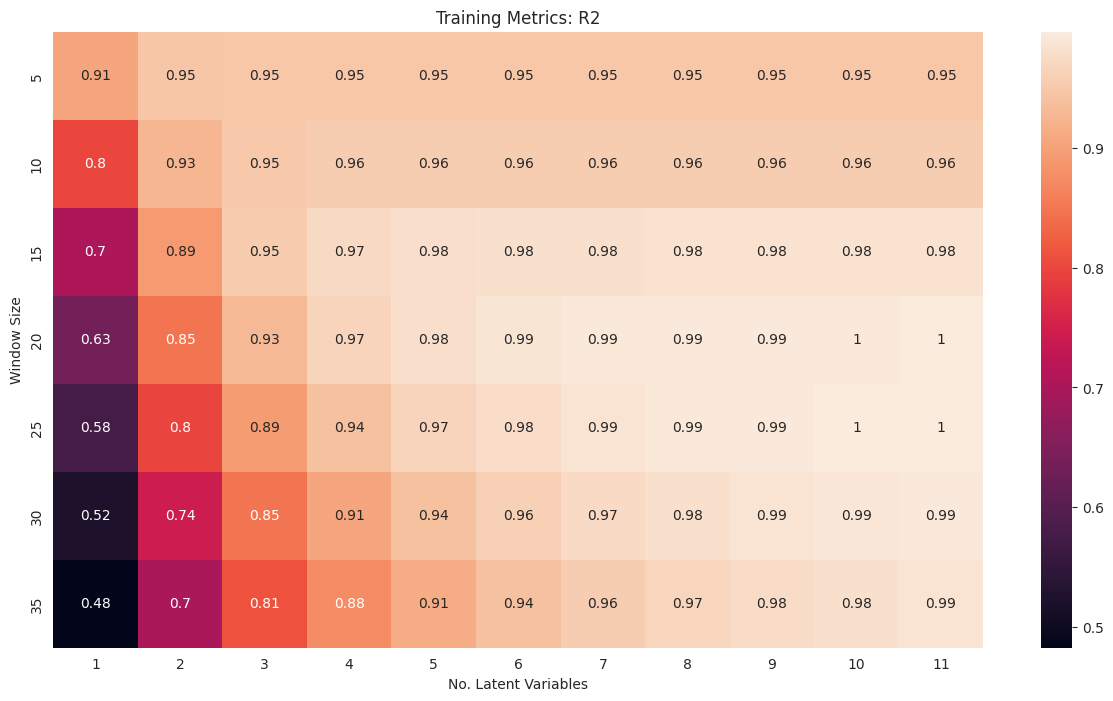

In [74]:
metrics = np.zeros((len(windows), lv_count))
for model in models:
    metric = np.array(model.train_metrics[2])
    if model.num_components > lv_count: 
        continue
    metrics[windows.index(model.window_size), model.num_components - 1] = np.mean(metric)

fig, _ = plt.subplots(figsize=(15, 8))
ax = heatmap(metrics, annot=True, xticklabels=range(1, lv_count+1), yticklabels=windows)
plt.title('Training Metrics: R2')
ax.set(ylabel="Window Size", xlabel="No. Latent Variables")
plt.show()


#### Show percentage of excluded test data

In [ ]:
plt.plot(windows, not_filtered_p)
plt.title('Percentage of Testing Data Used')
plt.xlabel('Window Size')
plt.show()

#### Show variable importances

In [ ]:
coeffs = []
for model in models[55].model[:]:
    try:
        coeffs.append(np.array(model.coef_.squeeze()))
    except:
        coeffs.append(coeffs[-1])
        
print(coeffs)
        
import matplotlib.pyplot as plt

color = [np.random.choice(range(256), size=3) / 256. for _ in range(df_array.shape[1] - 1)]

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(range(1, np.mean(np.array(coeffs), axis=0).shape[0] + 1), 
        np.mean(np.array(coeffs), axis=0), color=color)
ax.set_xticks(range(1, np.mean(np.array(coeffs), axis=0).shape[0] + 1))
ax.set_xticklabels(list(df.columns[:-1]) * 3, rotation="vertical")
plt.title('Regression Coefficients (all models)')
plt.show()

color = [np.random.choice(range(256), size=3) / 256. for _ in range(df_array.shape[1] - 1)]

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(range(1, np.mean(np.array(coeffs), axis=0).shape[0] + 1), 
        np.abs(np.mean(np.array(coeffs), axis=0)), color=color)
ax.set_xticks(range(1, np.mean(np.array(coeffs), axis=0).shape[0] + 1))
ax.set_xticklabels(list(df.columns[:-1]) * 3, rotation="vertical")
plt.title('Absolute Values of Regression Coefficients (all models)')
plt.show()

In [35]:
var_importance_ids = np.argsort(np.abs(np.mean(np.array(coeffs), axis=0)))
var_importance_ids

array([48, 44, 46, 13, 55, 16, 14, 25, 27, 11,  1, 49,  6, 50,  3, 32, 54,
       37, 31, 51, 23, 18, 10, 52,  0,  2, 35, 15, 22, 60, 61,  9, 28, 58,
        4, 56, 21, 36,  8, 12, 53, 39, 43, 29, 34, 24, 20, 33, 57, 42, 47,
        7, 30, 26, 17, 38, 59, 45, 62, 40,  5, 41, 19])